# Importing and processing data

In [ ]:
import os
import pickle
from PIL import Image
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
from pathlib import Path

import torchvision
from torchvision import datasets, models, transforms

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

import time
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
!pip install -U torch torchvision

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:  
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/simpsons/journey-springfield.zip'
DATA_DIR_PATH = Path(DATA_DIR)

In [ ]:
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d data_simps

In [ ]:


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Dataset with images, which in parallel
    - downloads them from folders
    - encodes class markers 
    - auguments the training set
    - scales the images and turns them into Torch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # list of files for the upload
        self.files = sorted(files)
        # work mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # to transrotm images into PyTorch tensors and normalise
        image_transforms = {
                      # Train with augmentation
                      'train':
                      transforms.Compose([
                          transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                          transforms.RandomPerspective(distortion_scale=0.1),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(size=RESCALE_SIZE),  
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])  # Imagenet standards
                      ]),
                      # Val without augmentation
                      'val':
                      transforms.Compose([
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=RESCALE_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
                      # Test without augmentation
                      'test':
                      transforms.Compose([
                          transforms.Resize(size=256),
                          transforms.CenterCrop(size=RESCALE_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ]),
        }
                
        
        x = self.load_sample(self.files[index])
        
        # Dependant on the state: return or not the class
        if self.mode == 'train':
            x = image_transforms['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = image_transforms['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = image_transforms['test'](x)
            return x
        
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

the statistics

In [ ]:
traindir = '/content/data_simps/train/simpsons_dataset/'
categories = []
img_categories = []
n_train = []
hs = []
ws = []

for d in os.listdir(traindir):
    categories.append(d)

    
    train_imgs = os.listdir(traindir + d)
    n_train.append(len(train_imgs))
    

    
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                        }).sort_values('category')

image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

Text(0.5, 1.0, 'Training Images by Category')

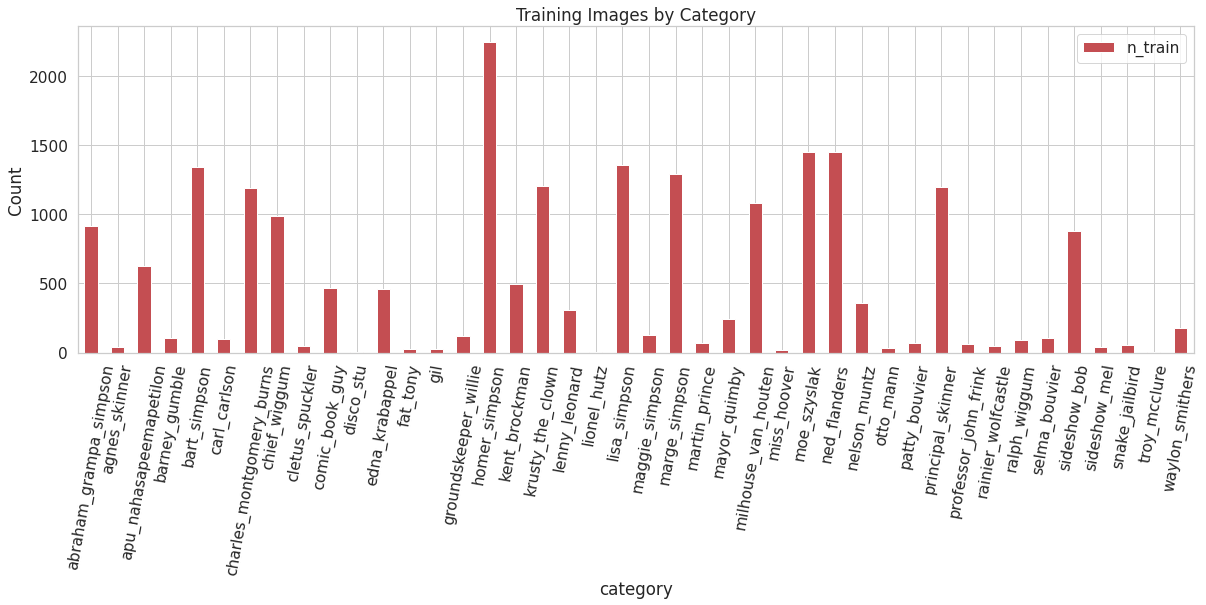

In [ ]:
cat_df.set_index('category').plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

Creating datasets

In [ ]:
# dataset's modes 
DATA_MODES = ['train', 'val', 'test']
# scale all the images to 224x224 px
RESCALE_SIZE = 224
# working on the videocard
DEVICE = torch.device("cuda")

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels, random_state=1)

In [ ]:
train_files_labels = [path.parent.name for path in train_files]
val_files_labels = [path.parent.name for path in val_files]

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Functions to draw random images



In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def imshow_train_val(nrows, ncols, mode):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        
        if mode == 'train':
          random_characters = int(np.random.uniform(0, len(train_dataset)))
          im_mode, label = train_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        elif mode == 'val':
          random_characters = int(np.random.uniform(0, len(val_dataset)))
          im_mode, label = val_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

        imshow(im_mode.data.cpu(), title=img_label,plt_ax=fig_x)

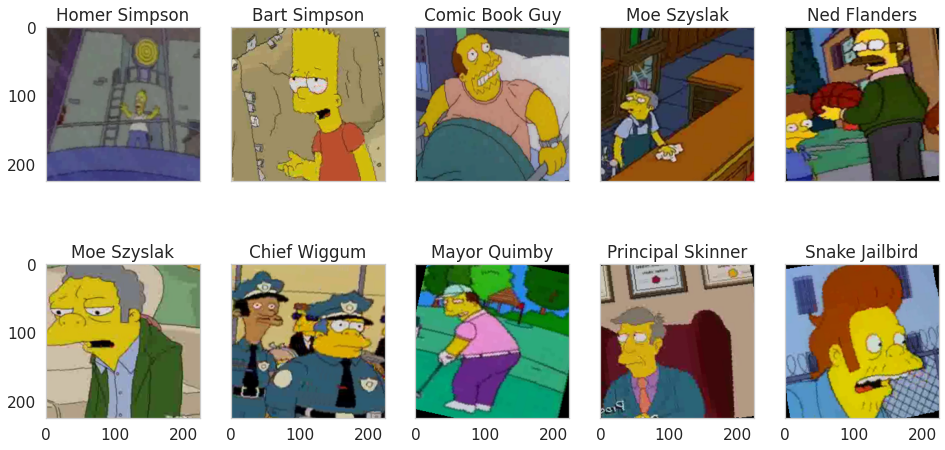

In [ ]:
imshow_train_val(2, 5, 'train')

# Training

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            random.seed(2147483647 + epoch)
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
                       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc)) 

    # loading best weights
    model.load_state_dict(best_model_wts)

    return model, history


def predict(model, test_loader):
    torch.manual_seed(1)
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def visual_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
model_mbnet = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

# Further training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# num_features -- dimensions of the feature-vector, fed to FC-layer
num_features = 1280

# n_classes - number of classes for classification
n_classes = len(np.unique(train_val_labels))

# changing Fully-Connected layer to our linear classificator
model_mbnet.classifier = nn.Sequential(
                      nn.Dropout(p=0.2, inplace=False),
                      nn.Linear(num_features, n_classes)
)


# transfering the model to GPU
model_mbnet = model_mbnet.to(DEVICE)

# cost function is cross enthropy
criterion_mbnet = nn.CrossEntropyLoss()

# optimizer is stochastic gradient descend. Only the last layer is learning.
optimizer_mbnet = optim.Adam(model_mbnet.parameters(), lr=1e-4)

# Multiplying learning_rate by 0.1 each 4 epochs
scheduler_mbnet = lr_scheduler.StepLR(optimizer_mbnet, step_size=4, gamma=0.1)

In [ ]:
%%time
model_mbnet, history = train(train_dataset, val_dataset, model_mbnet, epochs = 9, batch_size=32, 
                             criterion=criterion_mbnet, 
                             optimizer=optimizer_mbnet, 
                             scheduler=scheduler_mbnet
                             )

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 0.9031053465160043


epoch:  11%|█         | 1/9 [05:28<43:44, 328.06s/it]


Epoch 001 train_loss: 0.9031     val_loss 0.3786 train_acc 0.7973 val_acc 0.9112
loss 0.2927920709653423


epoch:  22%|██▏       | 2/9 [10:57<38:20, 328.66s/it]


Epoch 002 train_loss: 0.2928     val_loss 0.3037 train_acc 0.9226 val_acc 0.9241
loss 0.157910011099645


epoch:  33%|███▎      | 3/9 [16:23<32:46, 327.70s/it]


Epoch 003 train_loss: 0.1579     val_loss 0.2640 train_acc 0.9575 val_acc 0.9365
loss 0.1075239781927414


epoch:  44%|████▍     | 4/9 [21:51<27:17, 327.57s/it]


Epoch 004 train_loss: 0.1075     val_loss 0.2193 train_acc 0.9715 val_acc 0.9501
loss 0.04506432096775637


epoch:  56%|█████▌    | 5/9 [27:18<21:49, 327.39s/it]


Epoch 005 train_loss: 0.0451     val_loss 0.1844 train_acc 0.9904 val_acc 0.9608
loss 0.0371926662145943


epoch:  67%|██████▋   | 6/9 [32:49<16:25, 328.60s/it]


Epoch 006 train_loss: 0.0372     val_loss 0.1882 train_acc 0.9913 val_acc 0.9594
loss 0.032910907791044115


epoch:  78%|███████▊  | 7/9 [38:19<10:58, 329.18s/it]


Epoch 007 train_loss: 0.0329     val_loss 0.1868 train_acc 0.9927 val_acc 0.9608
loss 0.02796436263845959


epoch:  89%|████████▉ | 8/9 [43:49<05:29, 329.59s/it]


Epoch 008 train_loss: 0.0280     val_loss 0.1768 train_acc 0.9943 val_acc 0.9620
loss 0.023301832916427064


epoch: 100%|██████████| 9/9 [49:21<00:00, 329.07s/it]


Epoch 009 train_loss: 0.0233     val_loss 0.1785 train_acc 0.9954 val_acc 0.9632
Training complete in 49m 22s
Best val Acc: 0.963219
CPU times: user 40min 23s, sys: 9min 6s, total: 49min 30s
Wall time: 49min 21s


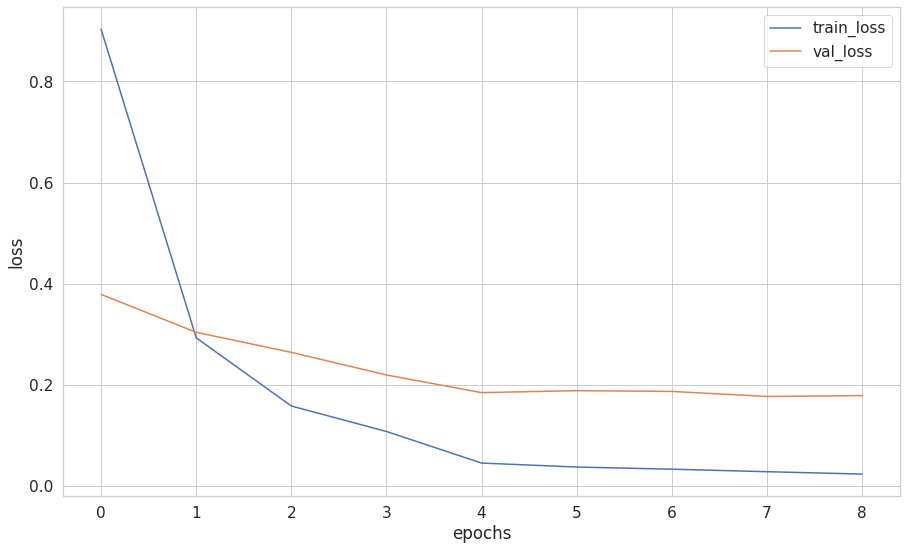

In [ ]:

torch.save(model_mbnet.state_dict(), Path('/content/gdrive/MyDrive/simpsons', 'model_mbnet_01.pth'))
visual_loss(history)

# Loading trained model

In [ ]:
model_mbnet.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/simpsons', 'model_mbnet_01.pth')))

<All keys matched successfully>

# Visualising the accuracy of the predictions

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
      inputs = inputs.to(device)
      model.eval()
      logit = model(inputs).cpu()
      probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs
def f1_val_score(num_samples, model):
  idxs = list(map(int, np.random.uniform(0, len(val_dataset), num_samples)))
  imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

  probs_ims = predict(model, imgs)

  y_pred = np.argmax(probs_ims,-1)
  actual_labels = [val_dataset[id][1] for id in idxs]

  return f1_score(actual_labels, y_pred, average='micro')

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
def visual_preds(nrows, ncols, model, label_encoder):

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_characters = int(np.random.uniform(0, len(val_dataset)))
      im_val, label = val_dataset[random_characters]
      img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        

      imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
        
      actual_text = "Actual : {}".format(img_label)
                
      fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
      font0 = FontProperties()
      font = font0.copy()
      font.set_family("serif")
      prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)
        
      predicted_label = label_encoder.classes_[y_pred]
      predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
                
      fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=10, color='black',fontweight='bold')

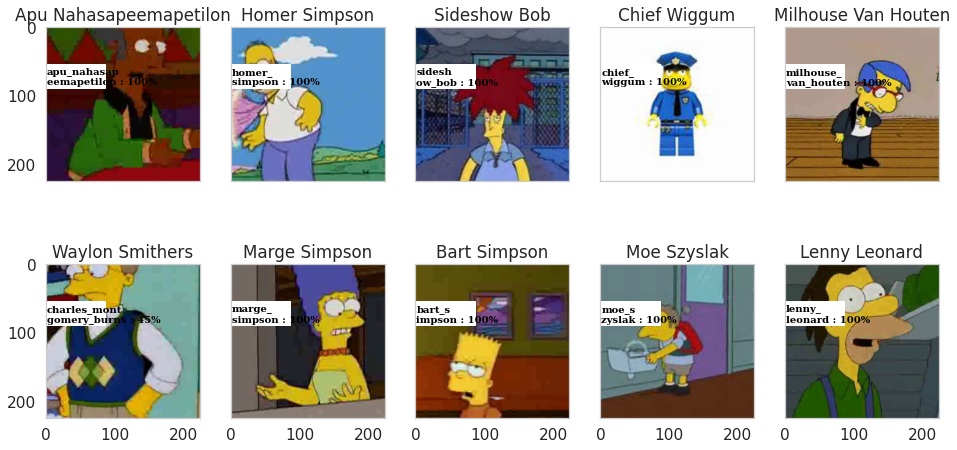

In [ ]:
visual_preds(2, 5, model_mbnet, label_encoder)

In [ ]:
def submit_df(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit

THE BEST SUBMIT

In [ ]:
my_submit_mbnet_01 = submit_df(model_mbnet, label_encoder, 64)
my_submit_mbnet_01.to_csv(Path('/content/gdrive/MyDrive/simpsons', 'mbnet_01_test_saved_model.csv'), index=False)

# Retraining the model on the validation dataset (score is still worse)

In [ ]:
val_dataset_for_train = SimpsonsDataset(val_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [ ]:
model_mbnet_val = models.mobilenet_v2()

In [ ]:
layers_to_unfreeze = 3

# Turning off the calculation of the gradients for layers we don't train
for param in model_mbnet_val.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- dimensions of the feature vector eaten by FC-layer
num_features = 1280

# n_classes - number of classes
n_classes = len(np.unique(train_val_labels))

# Fully-Connected layer substituted by our linear classifier
model_mbnet_val.classifier = nn.Sequential(
                      nn.Dropout(p=0.2, inplace=False),
                      nn.Linear(num_features, n_classes)
)


# tranferring to GPU
model_mbnet_val = model_mbnet_val.to(DEVICE)


# cost function
criterion_val = nn.CrossEntropyLoss()

# last "layers_to_unfreeze" layers from convolution part and fully connected layer
# parameters() returns the list of parameters, the lists are additive
optimizer_mbnet_val = optim.Adam(list(model_mbnet_val.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mbnet_val.classifier.parameters()), lr=1e-4)

# multiplying learning_rate by 0.1 each 3 epochs 
scheduler_mbnet_val = lr_scheduler.StepLR(optimizer_mbnet_val, step_size=3, gamma=0.1)

model_mbnet_val.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/simpsons', 'model_mbnet_01.pth')))

<All keys matched successfully>

In [ ]:
def train_onval(val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            random.seed(2147483647 + epoch)
            
            train_loss, train_acc = fit_epoch(model, val_loader, criterion, optimizer)
            print("loss", train_loss)

            scheduler.step()
            
            #history.append((train_loss, train_acc))

            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))
            
                       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc)) 

    # best weights to load
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [ ]:
%%time
model_mbnet_val = train_onval(val_dataset_for_train, model_mbnet_val, epochs = 6, batch_size=256, 
                             criterion=criterion_val, 
                             optimizer=optimizer_mbnet_val, 
                             scheduler=scheduler_mbnet_val
                             )

epoch:  17%|█▋        | 1/6 [00:51<04:19, 51.88s/it]

loss 0.2321510870950103

Epoch 001 train_loss: 0.2322     train_acc 0.9604


epoch:  33%|███▎      | 2/6 [01:43<03:26, 51.74s/it]

loss 0.2021577114602789

Epoch 002 train_loss: 0.2022     train_acc 0.9632


epoch:  50%|█████     | 3/6 [02:34<02:34, 51.49s/it]

loss 0.19386256807369182

Epoch 003 train_loss: 0.1939     train_acc 0.9611


epoch:  67%|██████▋   | 4/6 [03:26<01:42, 51.44s/it]

loss 0.18921078057171822

Epoch 004 train_loss: 0.1892     train_acc 0.9611


epoch:  83%|████████▎ | 5/6 [04:17<00:51, 51.51s/it]

loss 0.18053655523885997

Epoch 005 train_loss: 0.1805     train_acc 0.9632


epoch: 100%|██████████| 6/6 [05:09<00:00, 51.56s/it]

loss 0.18501602607579684

Epoch 006 train_loss: 0.1850     train_acc 0.9611
Training complete in 5m 9s
Best train Acc: 0.963219
CPU times: user 5min 4s, sys: 5.83 s, total: 5min 10s
Wall time: 5min 9s


In [ ]:
torch.save(model_mbnet_val.state_dict(), Path('/content/gdrive/MyDrive/simpsons', 'model_mbnet_02.txt'))
model_mbnet_val.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/simpsons', 'model_mbnet_02.txt')))

<All keys matched successfully>

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

def submit_df(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit


my_submit_mbnet_val = submit_df(model_mbnet_val, label_encoder, 128)
my_submit_mbnet_val.to_csv(Path('/content/gdrive/MyDrive/simpsons', 'mbnet_02.csv'), index=False)